In [1]:
# Imports as always.
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dataclasses
from dataclasses import dataclass

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms

from PIL import Image

from hflayers import Hopfield, HopfieldLayer, HopfieldPooling

from datetime import datetime

from tqdm.notebook import tqdm

from data_handling import ISICDataset

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121


# Deep Hopfield Networks for Lesion Segmentation

Lesion segmentation is the task of identifying lesions in medical imagery. More generally, image segmentation is the task of separating objects and layers within an image. 

There are plenty of lesion segmentation benchmarks on [paperswithcode.com](https://paperswithcode.com/task/lesion-segmentation). I quite like the look of the [ISIC Challenge Datasets](https://challenge.isic-archive.com/data/#2020), which ran as a competition between 2016 to 2020. We will use the ISIC 2018 set as there are reported scores for these that we can compare our results with.

[This](https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923) might be a nice series of articles to follow.

## Data Handling

In [2]:
# Pre-define a couple of transform functions to and from tensors and images.
tensor_to_image = transforms.ToPILImage()
image_to_tensor = transforms.ToTensor()

In [3]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory, 
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory, 
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

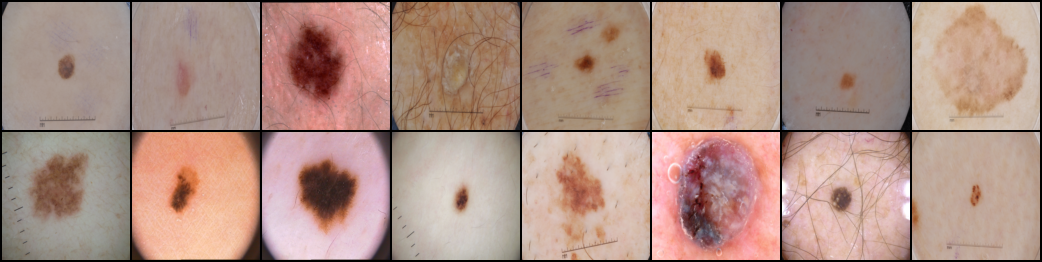

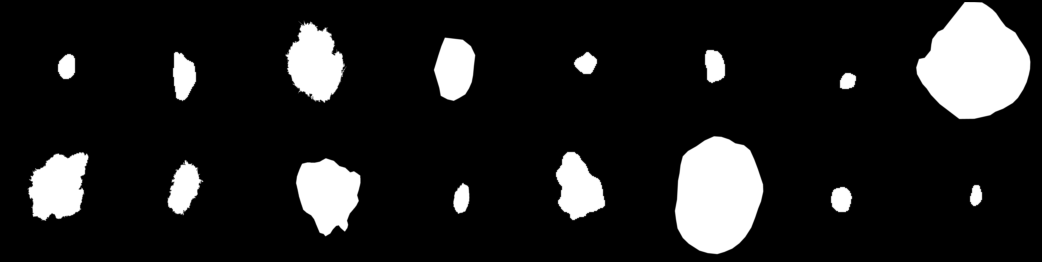

In [4]:
train_inputs, train_targets = next(iter(train_dataloader))

input_grid = torchvision.utils.make_grid(train_inputs, nrow=8)
display(tensor_to_image(input_grid))

target_grid = torchvision.utils.make_grid(train_targets, nrow=8)
display(tensor_to_image(target_grid))